In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fake-news/news.csv


In [2]:
import re
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score

# Keras imports
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D,Reshape
from keras.preprocessing.sequence import pad_sequences

# Load the dataset
data = pd.read_csv('/kaggle/input/fake-news/news.csv')
data.drop(['Unnamed: 0'], axis=1, inplace=True)
data['label'] = data['label'].map({'REAL': 0, 'FAKE': 1})

data.head(5)

,title,text,label
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",1
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,1
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,0
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",1
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,0


In [3]:
import matplotlib.pyplot as plt
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation', marker='o')
    plt.title('Model Accuracy')
    plt.xlabel('Eoochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Perda de treinamento e validação
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training', marker='o')
    plt.plot(history.history['val_loss'], label='Validation', marker='o')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [4]:
def preprocessing(title, text):
    # Combine the title and the text
    combined_text = title + " " + text
    combined_text = combined_text.strip()
    # ... additional preprocessing if needed ...
    return combined_text

# Apply preprocessing
data['combined_text'] = data.apply(lambda row: preprocessing(row['title'], row['text']), axis=1)

data.head(5)

,title,text,label,combined_text
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",1,You Can Smell Hillary’s Fear Daniel Greenfield...
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,1,Watch The Exact Moment Paul Ryan Committed Pol...
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,0,Kerry to go to Paris in gesture of sympathy U....
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",1,Bernie supporters on Twitter erupt in anger ag...
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,0,The Battle of New York: Why This Primary Matte...


In [5]:

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(data['combined_text'], 
                                                    data['label'], test_size=0.2, 
                                                    random_state=42)

# Initialize TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Convert to dense array for deep learning model
X_train_tfidf = X_train_tfidf.toarray()
X_test_tfidf = X_test_tfidf.toarray()

In [6]:
from keras.layers import Conv1D, GlobalMaxPooling1D

model = Sequential()

# Input layer (you might want to use an Embedding layer here if you switch to word embeddings)
model.add(Dense(64, input_shape=(10000,), activation='relu'))
model.add(Reshape((64, -1)))

# Convolutional Layer
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(GlobalMaxPooling1D())

# Dense Layer
model.add(Dense(32, activation='relu'))

# Output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                640064    
                                                                 
 reshape (Reshape)           (None, 64, 1)             0         
                                                                 
 conv1d (Conv1D)             (None, 60, 128)           768       
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                        

In [8]:
# Train the model (make sure your data is correctly shaped)
history = model.fit(X_train_tfidf, y_train, validation_data=(X_test_tfidf, y_test), epochs=10, batch_size=64)


Epoch 1/10
80/80 [==============================] - 2s 17ms/step - loss: 0.6542 - accuracy: 0.6093 - val_loss: 0.5091 - val_accuracy: 0.8358
Epoch 2/10
80/80 [==============================] - 1s 12ms/step - loss: 0.3160 - accuracy: 0.9193 - val_loss: 0.1983 - val_accuracy: 0.9329
Epoch 3/10
80/80 [==============================] - 1s 12ms/step - loss: 0.0981 - accuracy: 0.9745 - val_loss: 0.1532 - val_accuracy: 0.9416
Epoch 4/10
80/80 [==============================] - 1s 12ms/step - loss: 0.0309 - accuracy: 0.9949 - val_loss: 0.1583 - val_accuracy: 0.9424
Epoch 5/10
80/80 [==============================] - 1s 13ms/step - loss: 0.0123 - accuracy: 0.9986 - val_loss: 0.1677 - val_accuracy: 0.9416
Epoch 6/10
80/80 [==============================] - 1s 12ms/step - loss: 0.0077 - accuracy: 0.9992 - val_loss: 0.1700 - val_accuracy: 0.9448
Epoch 7/10
80/80 [==============================] - 1s 12ms/step - loss: 0.0063 - accuracy: 0.9992 - val_loss: 0.1788 - val_accuracy: 0.9440
Epoch 8/10
80

In [9]:
# Version 1: CNN with 10 epochs
loss, accuracy = model.evaluate(X_test_tfidf, y_test, verbose=0)
print(f'Accuracy: {round(accuracy*100,2)}%')

Accuracy: 94.24%


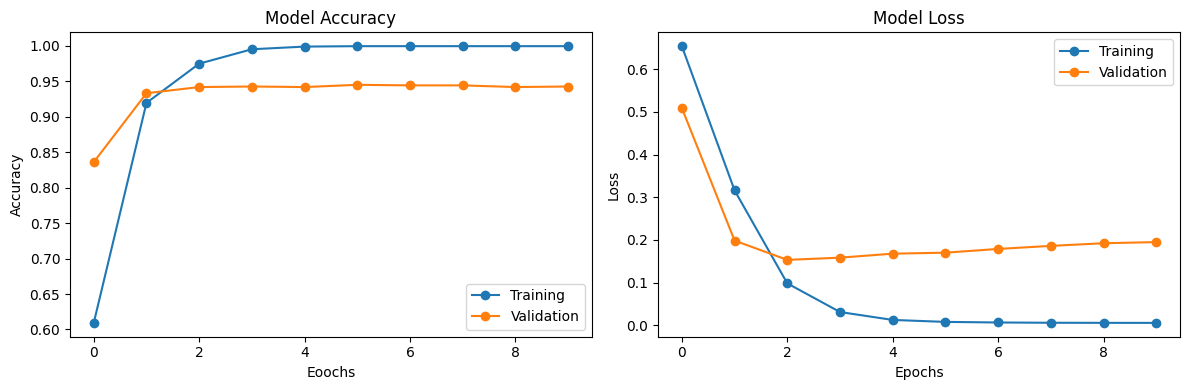

In [10]:
plot_training_history(history)

# Version 2: Separate Title and Text

In [11]:
def clean_text(text):
    text = text.strip()                         #Removes Extra White Spaces
    text = text.lower()                         #lowercase
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)     #Removes special characters
    
    return text

In [12]:
# Preprocessing the title and text separately
data['Clean_Title'] = data['title'].apply(clean_text)
data['Clean_Text'] = data['text'].apply(clean_text)


# Split the dataset
X_train_titles, X_test_titles, y_train, y_test = train_test_split(data['Clean_Title'], 
                                                    data['label'], test_size=0.2, 
                                                    random_state=42)
# Split the dataset
X_train_texts, X_test_texts, y_train, y_test = train_test_split(data['Clean_Text'], 
                                                    data['label'], test_size=0.2, 
                                                    random_state=42)

# Vectorize the title and text
title_vectorizer = TfidfVectorizer(max_features=5000)  # You might want fewer features for titles
text_vectorizer = TfidfVectorizer(max_features=10000)

X_train_titles = title_vectorizer.fit_transform(X_train_titles).toarray()
X_train_texts = text_vectorizer.fit_transform(X_train_texts).toarray()

X_test_titles = title_vectorizer.transform(X_test_titles).toarray()
X_test_texts = text_vectorizer.transform(X_test_texts).toarray()


In [13]:
from keras.layers import Input, Dense, concatenate
from keras.models import Model

# Title branch
title_input = Input(shape=(5000,), name='title_input')
title_branch = Dense(64, activation='relu')(title_input)
title_branch = Reshape((64, -1))(title_branch)
title_branch = Conv1D(128, 5, activation='relu')(title_branch)
title_branch = GlobalMaxPooling1D()(title_branch)

# Text branch
text_input = Input(shape=(10000,), name='text_input')
text_branch = Dense(64, activation='relu')(text_input)
text_branch = Reshape((64, -1))(text_branch)
text_branch = Conv1D(128, 5, activation='relu')(text_branch)
text_branch = GlobalMaxPooling1D()(text_branch)

# Combine branches
combined = concatenate([title_branch, text_branch])

# Add final layers
combined = Dense(64, activation='relu')(combined)
output = Dense(1, activation='sigmoid')(combined)

model = Model(inputs=[title_input, text_input], outputs=output)


In [14]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit([X_train_titles, X_train_texts], y_train, 
            validation_data=([X_test_titles, X_test_texts], y_test), 
            epochs=10, batch_size=32)


Epoch 1/10
159/159 [==============================] - 3s 13ms/step - loss: 0.4538 - accuracy: 0.7646 - val_loss: 0.1847 - val_accuracy: 0.9234
Epoch 2/10
159/159 [==============================] - 2s 11ms/step - loss: 0.0890 - accuracy: 0.9714 - val_loss: 0.1558 - val_accuracy: 0.9408
Epoch 3/10
159/159 [==============================] - 2s 11ms/step - loss: 0.0106 - accuracy: 0.9980 - val_loss: 0.1610 - val_accuracy: 0.9376
Epoch 4/10
159/159 [==============================] - 2s 11ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.1790 - val_accuracy: 0.9440
Epoch 5/10
159/159 [==============================] - 2s 12ms/step - loss: 6.7194e-04 - accuracy: 1.0000 - val_loss: 0.1860 - val_accuracy: 0.9432
Epoch 6/10
159/159 [==============================] - 2s 11ms/step - loss: 3.7525e-04 - accuracy: 1.0000 - val_loss: 0.1943 - val_accuracy: 0.9432
Epoch 7/10
159/159 [==============================] - 2s 11ms/step - loss: 2.3978e-04 - accuracy: 1.0000 - val_loss: 0.1997 - val_accu

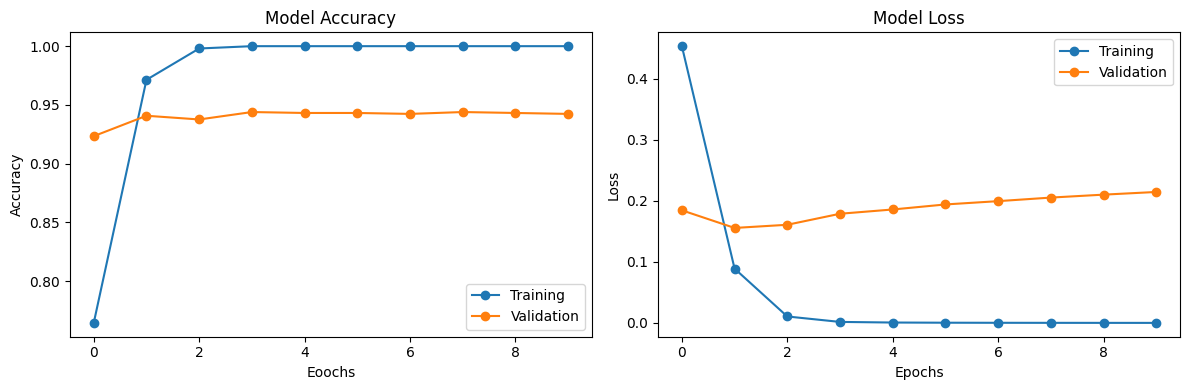

In [15]:
plot_training_history(history)

In [16]:
# Version 2: CNN with Separate processing for 
loss, accuracy = model.evaluate([X_test_titles, X_test_texts], y_test, verbose=0)
print(f'Accuracy: {round(accuracy*100,2)}%')

Accuracy: 94.24%


In [17]:
model.save('fakenews_cnn_model.h5')


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [18]:
import joblib
joblib.dump(title_vectorizer, 'title_vectorizer.pkl')
joblib.dump(text_vectorizer, 'text_vectorizer.pkl')
joblib.dump(scaler, 'scaler.pkl')


NameError: name 'scaler' is not defined